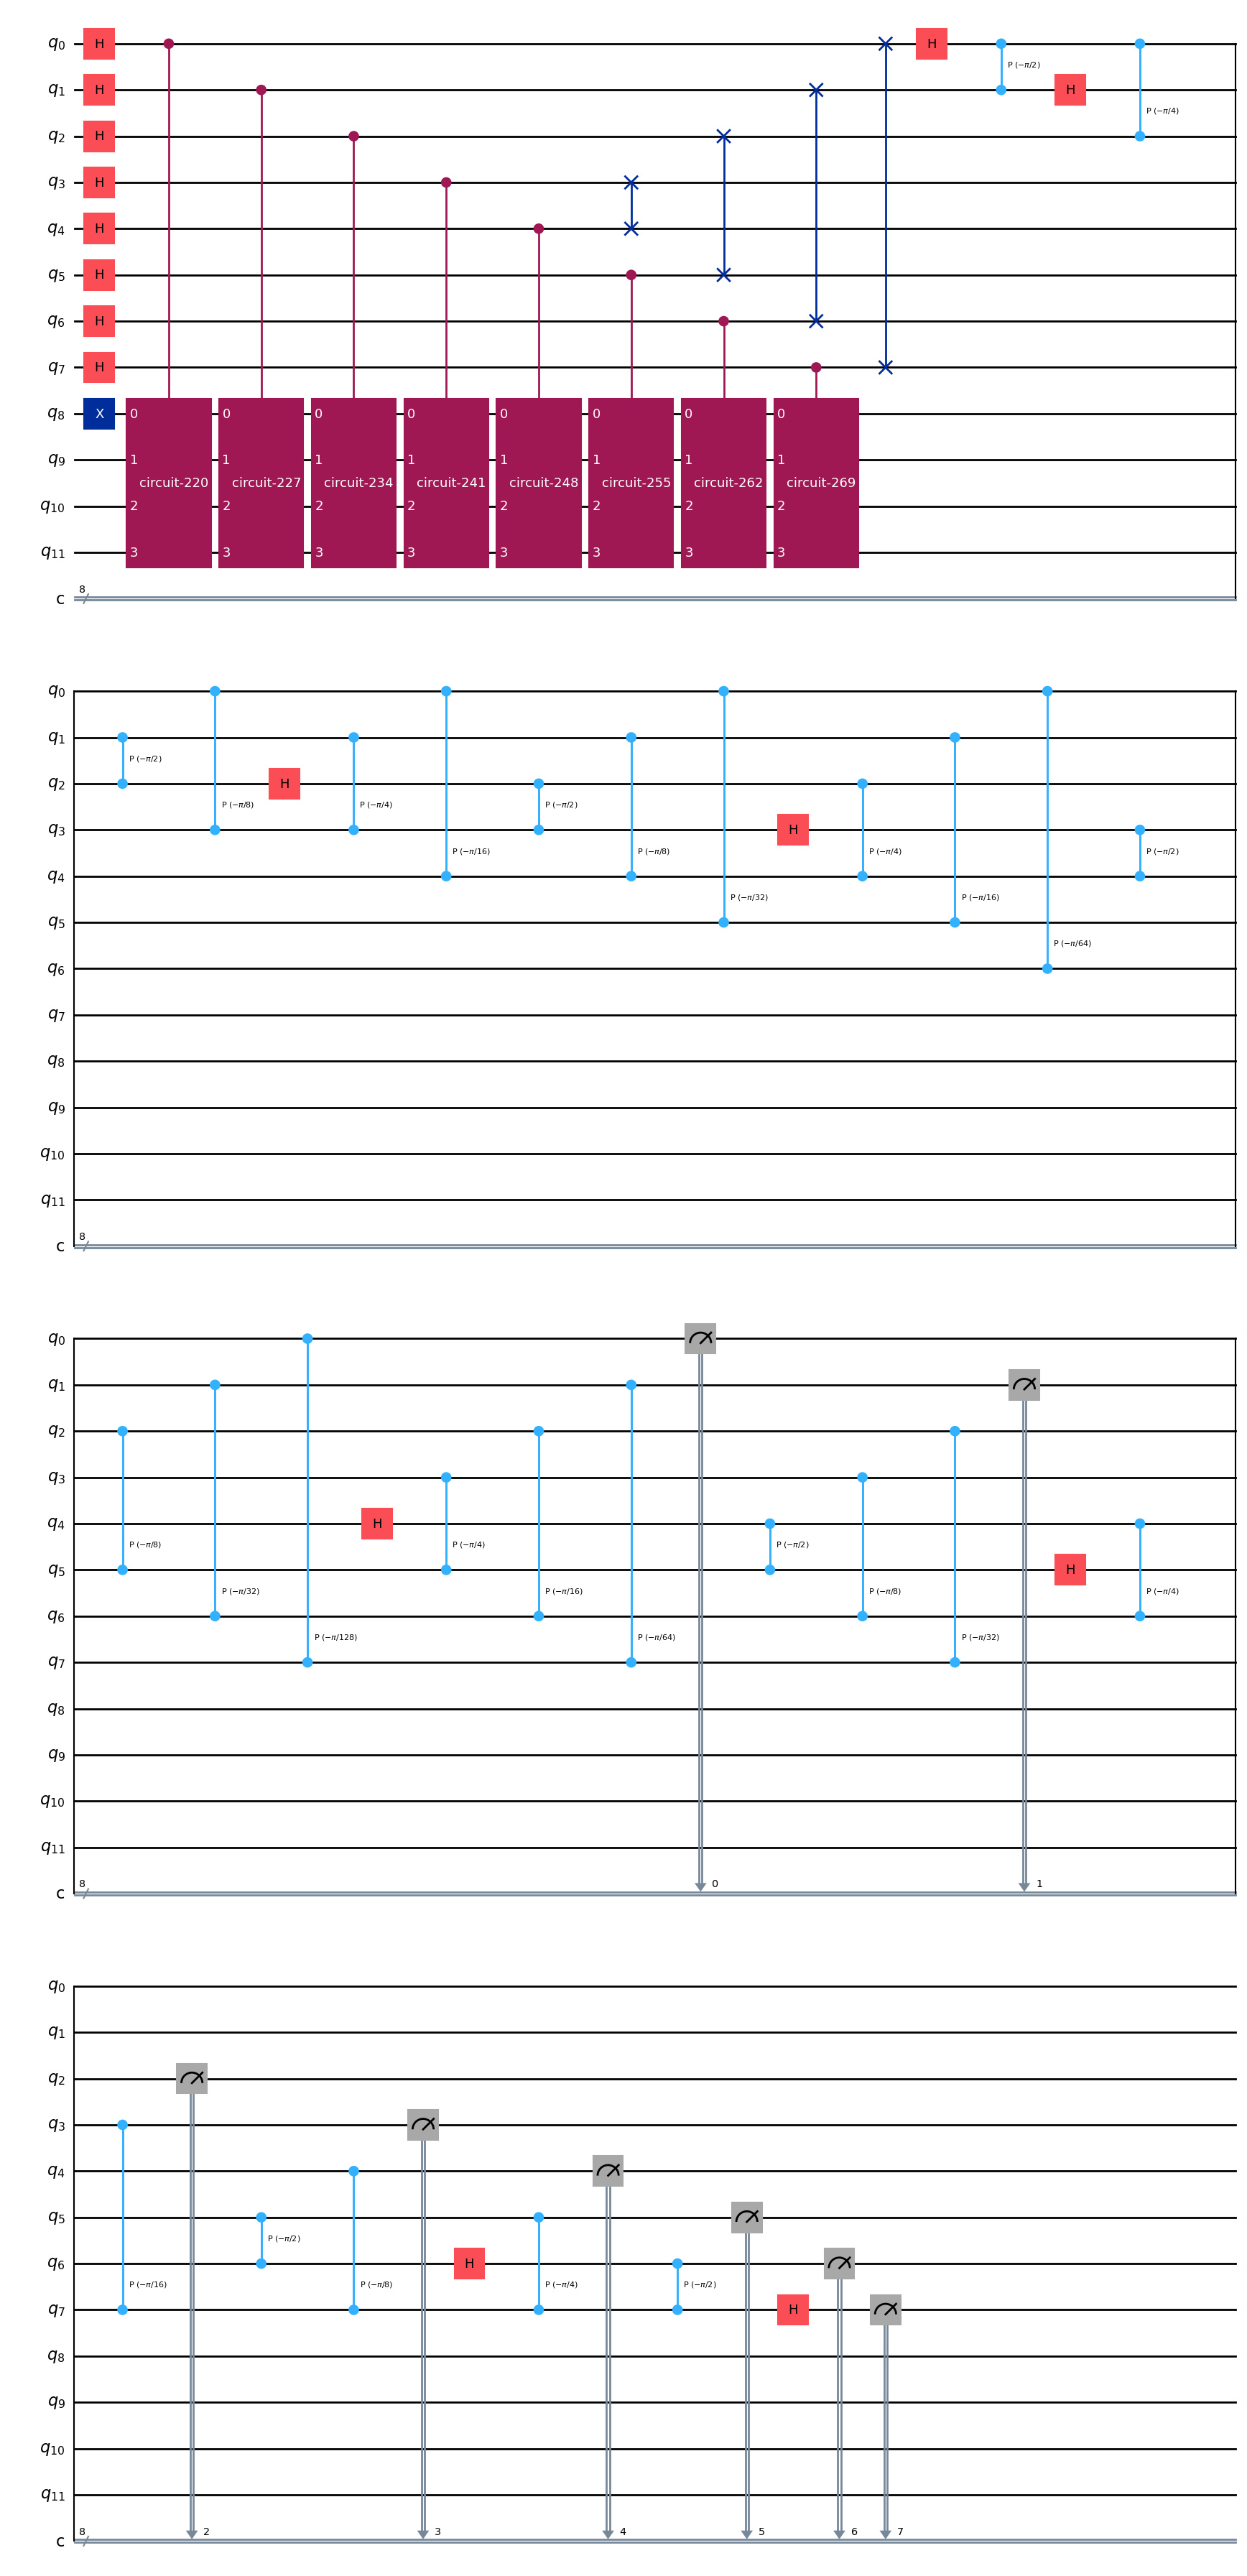

In [ ]:
import numpy as np
from numpy import pi
import math
import matplotlib.pyplot as plt
# Qiskitから必要なモジュールをインポート
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram

# cmul_mod15関数（位相推定に使用）
# この関数は、位相推定に使うための「制御付き」モジュラー乗算（ここではmod15）ゲートを作成します。
# 4量子ビットの回路を作り、指定回数だけスワップゲートを連続して適用することで、ある種の操作（例えば乗算に対応する操作）をエンコードしています。
# その後、生成した回路をゲートに変換し、制御付きゲート（control gate）として返しています。
def cmul_mod15(repetitions):
    U = QuantumCircuit(4)
    for i in range(repetitions):
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    U = U.to_gate()
    c_U = U.control(1)
    return c_U

# 逆量子フーリエ変換関数を用意
# 量子フーリエ変換の各段階で必要な制御位相回転とアダマールゲートを適用します。
# 量子状態の位相を逆方向に回転させ、後の測定で正しい位相情報を得られるようにしています。
def qft_rotate_single_inv(circuit, i, n):
    if n == 0:
        return circuit
    for qubit in range(0, i):
        circuit.cp(-pi / 2**(i - qubit), qubit, i)
    circuit.h(i)

# n 個のエンコード量子ビットに対して逆QFTを実装します。
# まず、量子ビットの順序を反転するスワップ操作を行い、次に各ビットに対して逆位相回転を適用しています。
def qft_dagger(circuit, n):
    for i in range(math.floor(n / 2)):
        circuit.swap(i, n - (i + 1))
    for i in range(n):
        qft_rotate_single_inv(circuit, i, n)



################################
#### アルゴリズムの本体
################################
n_encode = 8  # 求めたい固有値の位相角をエンコードする量子ビット数
n_eigstate = 4  # 固有状態の量子ビット数
qc = QuantumCircuit(n_encode + n_eigstate, n_encode)

# エンコードビットにHadamardゲートを適用
for i in range(n_encode):
    qc.h(i)

# 固有状態の準備
qc.x(n_encode)

# cmul_mod15ゲートを位相推定に使用
repetitions = 1
for count in range(n_encode):
    qc.append(cmul_mod15(repetitions), [count] + [8, 9, 10, 11])  # 各エンコードビットに対して、制御付きのモジュラー乗算ゲート（cmul_mod15）を適用しています。
    repetitions *= 2  # 各段階で repetitions の値を2倍にすることで、量子位相推定に必要な位相の「重み付け」を実現しています。


# 逆量子フーリエ変換
qft_dagger(qc, n_encode)  # 逆QFT：エンコードした位相情報を元に戻し、測定可能な状態に変換します。

# 測定
for i in range(n_encode):
    qc.measure(i, i)

qc.draw(output='mpl')


####
# 補足
####
# qc.append(cmul_mod15(repetitions), [count] + [8, 9, 10, 11])
# この [8, 9, 10, 11] は、ショアのアルゴリズムで用いる固有状態をエンコードするための4量子ビットのインデックスを示しています。具体的には、全体の回路は8個の位相エンコード用量子ビット（インデックス 0～7）と4個の固有状態用量子ビット（インデックス 8～11）から構成されます。
# この行で、cmul_mod15 ゲートは制御付きゲートとして、制御ビットが [count]（すなわち 0～7 の各位相エンコード用量子ビット）に作用し、ターゲットビットとして [8, 9, 10, 11]（固有状態を保持するレジスタ）に作用する形で追加されています。
# これにより、各位相エンコード用量子ビットの状態に基づいて、固有状態レジスタに対してモジュラー乗算操作（mod15）が適用され、後の位相推定処理に必要な位相情報がエンコードされます。


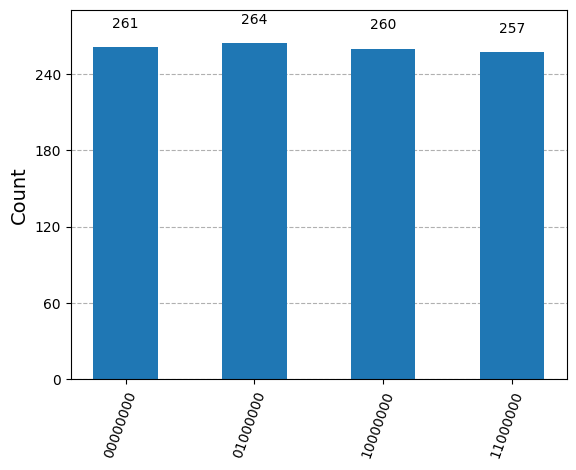

In [2]:
# AerSimulatorを使用して実行
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1042).result()

# 結果を取得して表示
answer = result.get_counts()
plot_histogram(answer)